# Comparison-based surrogate representations for low-cost similarity search


## Introduction
The similarity search problem is a well-known tool y several computational fields...

The solution of a $k$ nearest neighor query $knn(X, d, q, k)$ is the set of $k$ objects in $X$ that are closer to $q$ under the distance function $d$.
The naïve solution evaluates all $\{d(x, q) \mid x \in X\}$ and select the $k$ elements closer to $q$. While this procedure can be enough for small datasets, the performance can be improved for large datasets if the datasets is preprocessed to create a metric index that can reduce the search cost.
Even with competitive algorithms, the metric search is doomed and will revise the entire dataset depending on its dimensionality. In this situation, the strategy becomes trading quality by speed, and the approximated and probabilistic algorithms come into the scene.

The set of issues also include the memory requirements, which can vary due to the data composition.
Typically, the dataset is a set of high-dimensional vectors under some Minkowski distance function.
...

## Objetive

Given a metric database $(X, d)$, the core idea is to create a surrogate representation $(X', d')$ that captures the structure of the original metric space such that it can be used instead to reduce the computational requirements of the original specification. Therefore, our objective is to achieve that $\texttt{sizeof}(X) \gg \texttt{sizeof}(X')$ and $$\frac{|knn(X, d, q, k) \cap knn(X', d', q', \beta k)|}{k} \leq \alpha.$$


## Methods

This notebook introduces several different surrogated representations for high dimensional vector databases, most of them measured with cosine distance and one of them with the Euclidean distance.


### Binary Hamming Surrogate

Defines a binary hamming space surrogation $(X', d')$ of dimension `npairs` ($np$), i.e., $X'_{np \times n}$ boolean matrix. The encoding algorithm selects $np$ pairs of components, and for some vector $u$, it encodes each pair $i, j$ as

- $u[i] < u[j] \rightarrow 0$
- $u[i] \geq u[j] \rightarrow 1$

The $np$ bits are concatenated to obtain a binary fingerprint capturing relations among components. This fingerprint requires the use of the binary hamming distance to compute the similarity between two surrogated objects.

Note: We selected pairs among the set of $\frac{n^2}{2} + \frac{n}{2}$ matrix of comparisons. 


### MaxHash
Resembles the idea of _minhash_ but capturing large elements instead of minor ones in the idea that those components are crucial for some distance functions. It uses several samples each one is used to create a single hash value (the component-id that contains the greatest value among the sample). The sample size is quite important (smaller ones seem to be pretty effective). Each maxhash is concatenated and a string representation is generated. We used string hamming as distance function.

...

### Permutations

### Binary Permutations

We applied the _brief permutations_ idea but instead of using object references as permutations, here we used component values. We also applied the $modulus=1/3$.



In [1]:
using Pkg
Pkg.activate(".")
using Queryverse, Glob, JSON, CSV, DataFrames, DisplayAs
#using SimilaritySearch, SimSearchManifoldLearning, JLD2, JSON, Plots, LinearAlgebra, HypertextLiteral

  Activating project at `~/Research/SurrogateDistanceModels/notebooks`


In [2]:
function read_dataframe(pat)
    J = JSON.parse.(read.(glob("../data/*$pat*.json"), String))
    for j in J
        j["surrogate"] = get(j, "surrogate", "plain")
    end
    
    T = DataFrame.(J)
    reduce((a,b) -> vcat(a, b; cols=:union), T) |> @filter(_.surrogate != "Perms") |> @mutate(mem=ceil(Int, _.mem/2^20)) |> DataFrame
end

read_dataframe (generic function with 1 method)

In [3]:
function nick(r)
    m = string(r.method, " ", r.surrogate)
    if r.surrogate == "BHS"
        #rnd = 100
        #np = ceil(Int, get(r.npairs) / rnd) * rnd
        string(m, " np=", get(r.npairs))
    elseif r.surrogate == "MaxHash"
        string(m, " ss=", get(r.samplesize))
    elseif r.surrogate == "BinPerms"
        string(m, " #P=", get(r.nperms))
    else
        m
    end
end

nick (generic function with 1 method)

In [15]:

function plot_performance(D, title)
    #D |> @mutate(nick=nick(_.method,  _.surrogate), size=(_.mem)^2) |> @vlplot(
    D |> @mutate(nick=nick(_), size=(_.mem)) |> @vlplot(
        mark={
            :point,
            point={filled=false, fill=:white}
        },
        x={
            field=:recall
        },
        y={
            field=:searchtime,
            scale={type="log", base="10"}
        },
        color={
            :nick,
            title="color",        
        },
        shape={
            field=:surrogate
        },
        size="size:q",
        width=600,
        height=400,
        title=title
    ) |> DisplayAs.PNG
end

plot_performance (generic function with 1 method)

In [5]:
function plot_encode(D, title)
    #D |> @mutate(nick=nick(_.method,  _.surrogate), size=(_.mem)^2) |> @vlplot(
    D |> @mutate(nick=nick(_), size=(_.mem)^2) |> @vlplot(
        mark={
            :point,
            point={filled=false, fill=:white}
        },
        x={
            field=:recall
        },
        y={
            field=:enctime
        },
        color={
            :nick,
            title="color",        
        },
        shape={
            field=:surrogate
        },
        size="size:q",
        width=600,
        height=400,
        title=title
    ) |> DisplayAs.PNG
end

plot_encode (generic function with 1 method)

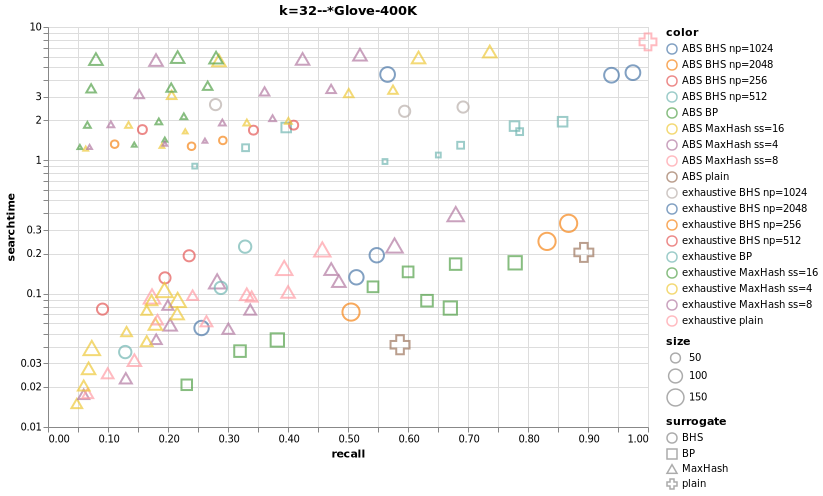

In [16]:
name = "k=32--*Glove-400K"
D = read_dataframe(name) # |> @filter(_.surrogate in ("BHS", "BP", "plain")) |> DataFrame
plot_performance(D, name) |> display
# plot_encode(D, name)

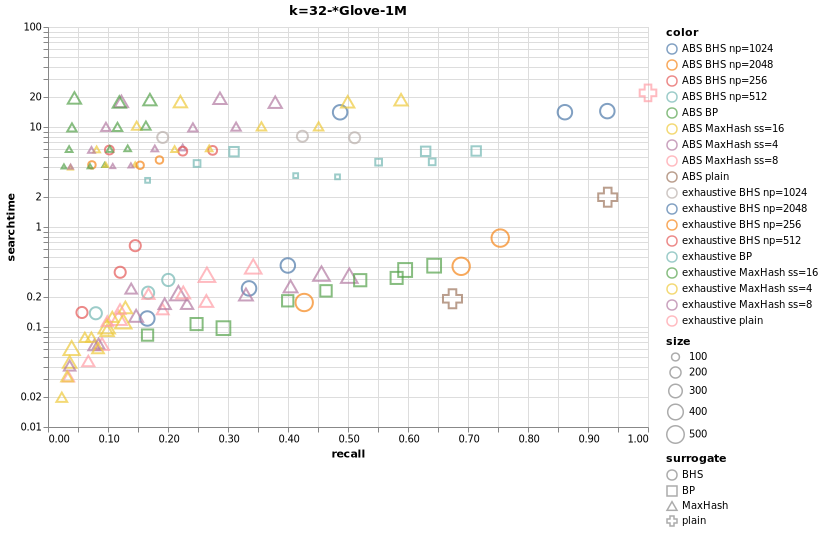

In [17]:
name = "k=32-*Glove-1M"
D = read_dataframe(name)
plot_performance(D, name)

In [ ]:
name = "WIT-300K"
D = read_dataframe(name)
plot_performance(D, name)

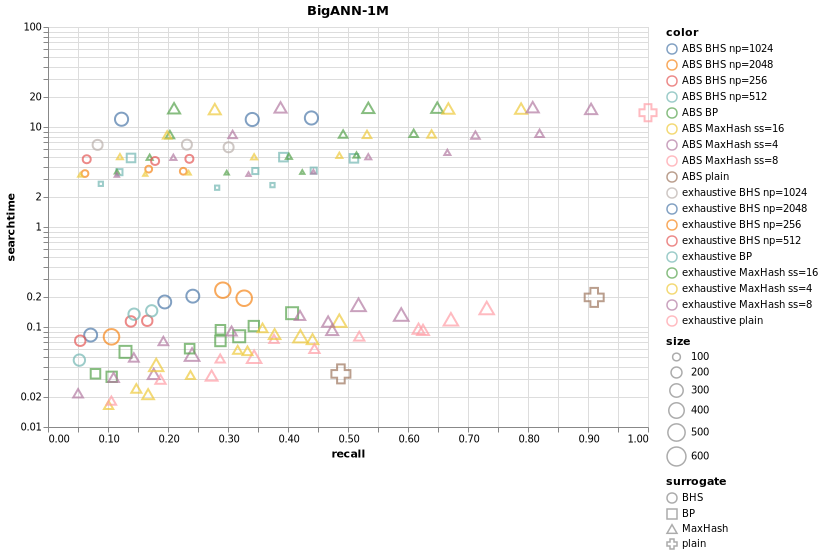

In [19]:
name = "BigANN-1M"
D = read_dataframe(name)
plot_performance(D, name)